<a href="https://colab.research.google.com/github/Saleem146/ProjetSpark/blob/main/Transfert_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [ ]:
# curl: download data and save to file
! curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
! tar xzf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  29.4M      0  0:01:29  0:01:29 --:--:-- 29.9M


# Import Libraries

In [ ]:
import pathlib

import cv2
import datetime
import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub


from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [ ]:
# verify version keras
keras.__version__

'2.8.0'

# Constante


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import yaml
#import yaml

yaml_file = open("/content/drive/MyDrive/model/learn.yaml", 'r')
yaml_content = yaml.load(yaml_file)

print("Key: Value")
for key, value in yaml_content.items():
   print(f"{key}: {value}")


Key: Value
IMAGE_WIDTH: 128
IMAGE_HEIGHT: IMAGE_WIDTH
IMAGE_DEPTH: 3
DATA_DIR_TRAIN_MANUFACTURER: /content/dataset/data/images_manufacturer_train.txt
DATA_DIR_TRAIN_FAMILY: /content/dataset/data/images_family_train.txt
DATA_DIR_TRAIN_VARIANT: /content/dataset/data/images_variant_train.txt
DATA_DIR_TEST_MANUFACTURER: /content/dataset/data/images_manufacturer_test.txt
DATA_DIR_TEST_FAMILY: /content/dataset/data/images_family_test.txt
DATA_DIR_TEST_VARIANT: /content/dataset/data/images_variant_test.txt
TARGET_NAME: manufacturer
TARGET_NAME2: family
TARGET_NAME3: variant


In [ ]:

DATA_DIR = yaml_content['DATA_DIR_TRAIN_FAMILY']
TARGET_NAME = yaml_content['TARGET_NAME']
TARGET_NAME2 = yaml_content['TARGET_NAME2']
TARGET_NAME3 = yaml_content['TARGET_NAME3']
DATA_DIR_TRAIN_MANUFACTURER = yaml_content['DATA_DIR_TRAIN_MANUFACTURER']
DATA_DIR_TRAIN_FAMILY = yaml_content['DATA_DIR_TRAIN_FAMILY']
DATA_DIR_TRAIN_VARIANT = yaml_content['DATA_DIR_TRAIN_VARIANT']
DATA_DIR_TEST_MANUFACTURER = yaml_content['DATA_DIR_TEST_MANUFACTURER']
DATA_DIR_TEST_FAMILY = yaml_content['DATA_DIR_TEST_FAMILY']
DATA_DIR_TEST_VARIANT = yaml_content['DATA_DIR_TEST_VARIANT']

#NB: Choose your target (manufacturer or family)

In order to use the same code to make the detection for the category "manufacturer" and "family", we overwrite the data with the code below.

In [ ]:
# allow to do for the manfacturer without restarting the constants part
TARGET_NAME2= TARGET_NAME
DATA_DIR_TRAIN_FAMILY=DATA_DIR_TRAIN_MANUFACTURER
DATA_DIR_TEST_FAMILY=DATA_DIR_TEST_MANUFACTURER

In [ ]:
IMAGE_SHAPE = (224, 224)
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_DEPTH = 3

# Function buil_image_database()

In [ ]:
# allow to build our image database
def build_image_database(path, target):
    """Build a pandas dataframe with target class and access path to images.
   
    Parameters
    - - - - - -
    path (Path): path patern to read csv file containing images information.
    target (str): name of the target column.
   
    Returns
    - - - - -
    A pandas dataframe, including target class and path to image.
    """
   
   
    _df = pd.read_csv(path, sep='\t',
            names=['all'],
            dtype={'all': str} # ids are not int but string
            )

    # la fonction split() découpe sur une chaîne de charatères
    _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

    # la fonction '<car>'.join(liste) concatène les éléments de liste en utilisant le séparateur <car>
    _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    # la colonne path contient le chemin d'accès à l'image
    _df['path'] = _df['image_id'].apply(lambda x:  pathlib.Path('dataset/data/images') / (x + '.jpg'))

    return _df.drop(columns=['all'])

## Verify of the function build_image_database()

In [ ]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_FAMILY, TARGET_NAME2).head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [ ]:
# apply build_image_database()
build_image_database(DATA_DIR_TRAIN_VARIANT, TARGET_NAME3).head(2)

,image_id,variant,path
0,1025794,707-320,dataset/data/images/1025794.jpg
1,1340192,707-320,dataset/data/images/1340192.jpg


In [ ]:
# apply build_image_database() in order to create the dataframe manufacturer_df
manufacturer_df = build_image_database(DATA_DIR_TRAIN_MANUFACTURER,TARGET_NAME)

In [ ]:
# see the dataframe manufacturer_df
manufacturer_df.head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


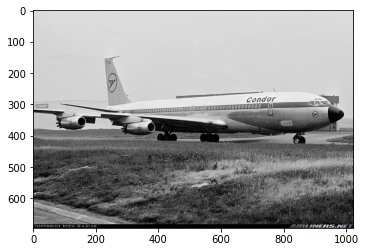

In [ ]:
# show the image in manufacturer_df
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

# Function Show_image()

In [ ]:
# the function :
# - take a df(argument)
#-take a row(row : argument)
#-take a column (target : argument)
# -it displays (the value of target ) and the associated image, for the line in argument


def show_image(df, row, target):
  """ Show an image from an image database , with the associated class

  Parameters
  -----------
  df(pd.DataFrame): images definition dataframe
  row(int):row index in df of image to be displayed
  target(str):name of target column

  Returns
  --------
  None
  """
  assert target in df.columns, "missing target column in dataframe"
  assert 'path' in df.columns , "Missing image path in dataframe"
  print(df.iloc[row, ][target])
  plt.imshow(plt.imread(df.iloc[row, ]['path']))
  return

# Function load_resize_image()

In [ ]:
def load_resize_image(path,height,width):
  """Load an image and resize it to the target size
    Parameters
    --------
    path(Path): access path to image file
    height(int): resize image to this height
    width(int):resize image to this width

    Returns
    ----------
    nb.array containing resize



  """
  
  return np.array(Image.open(path).resize((width, height)))

# Function build_x_and_y()

Build train & test set

In [ ]:
def build_x_and_y(df:pd.DataFrame,target:str,images:str,stratify=None):
  """Build x tensor and y tensor for model fitting 

  Parameters
  --------------
  df(pd.DataFrame):dataframe contanining images and target
  target(str):name of target column
  images(str): name of images column
  
  Returns
  ---------
  x(np.array):tensor of x values
  y(np.array):name of y values
  """
  x=np.array(df[images].to_list())
  #y= tf.keras.utils.to_categorical(df[target].astype('category').cat.codes)
  y = np.array(df[target].astype("category").cat.codes)


  return x, y


In [ ]:
# Load train & test dataset

train_df= build_image_database(DATA_DIR_TRAIN_FAMILY,TARGET_NAME2)
test_df= build_image_database(DATA_DIR_TEST_FAMILY,TARGET_NAME2)

train_df['resized_image']=train_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)

test_df['resized_image']=test_df.apply(lambda r:load_resize_image(r['path'],IMAGE_HEIGHT,IMAGE_WIDTH),axis=1)
#train_df
# Build tensors for training & testing

X_train,y_train =build_x_and_y(train_df,TARGET_NAME2,'resized_image')
X_test,y_test =build_x_and_y(test_df,TARGET_NAME2,'resized_image')



In [ ]:
def classify_images(images, model, classes_names=None):
  """Classify images through a TF model.
  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/ Keras model
  classes_names: dictionnary with classes names
  Returns
  -------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax returns the index of the max value per row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes

Train model

In [ ]:
# Flatten our train and test datasets

X_train_scaled = X_train / 255
X_test_scaled = X_test / 255


# Train our model using the plane datasets


In [ ]:
from tensorflow_hub.keras_layer import KerasLayer
# PreEntrainer le model en utlisant image_net de google

# On conserve les premiere couche 
feature_extractor_model = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/5"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH), trainable=False
)

In [ ]:
# See the model: number of parameters to comput

num_of_plane = train_df[TARGET_NAME2].nunique()

model_tl = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_plane)
])

model_tl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              410208    
                                                                 
 dense (Dense)               (None, 30)                38430     
                                                                 
Total params: 448,638
Trainable params: 38,430
Non-trainable params: 410,208
_________________________________________________________________


In [ ]:
# Train the model

model_tl.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model_tl.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
105/105 [==============================] - 10s 61ms/step - loss: 2.5447 - acc: 0.2552
Epoch 2/5
105/105 [==============================] - 6s 61ms/step - loss: 1.8226 - acc: 0.4325
Epoch 3/5
105/105 [==============================] - 6s 61ms/step - loss: 1.5065 - acc: 0.5351
Epoch 4/5
105/105 [==============================] - 7s 62ms/step - loss: 1.3115 - acc: 0.6101
Epoch 5/5
105/105 [==============================] - 6s 61ms/step - loss: 1.1733 - acc: 0.6554


In [ ]:
# see the argmax of the predict

np.argmax(model_tl.predict(X_test_scaled), axis=1)

array([ 4,  4,  4, ..., 17, 27, 29])

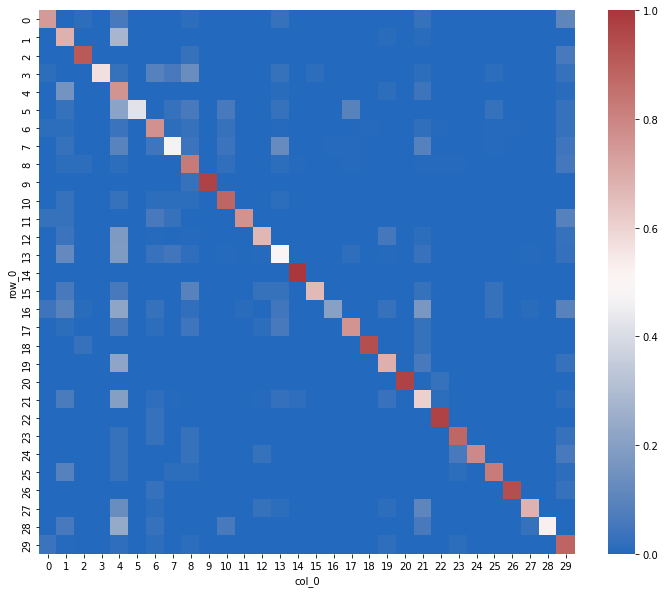

In [ ]:
# see the confusion matrix in the train

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(y_train, 
                        classify_images(X_train_scaled, model_tl), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

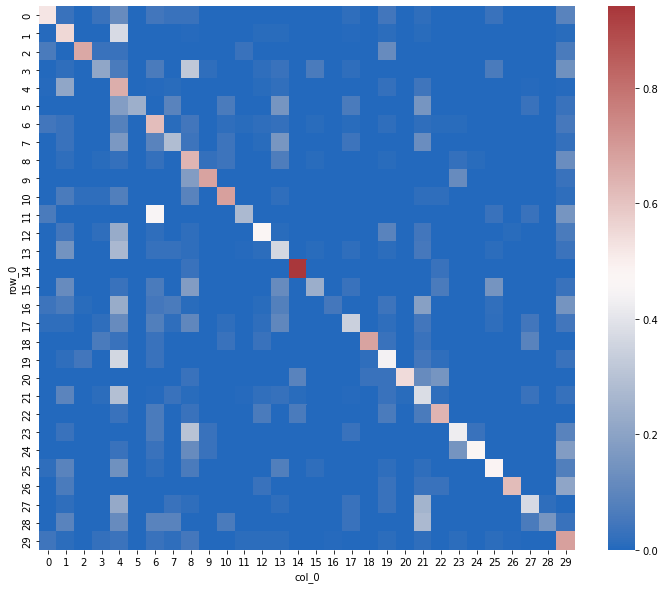

In [ ]:
# see the confusion matrix of the test without names

import seaborn as sns

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(y_test, 
                        classify_images(X_test_scaled, model_tl), 
                        normalize='index'),
            cmap='vlag',
            ax=ax)

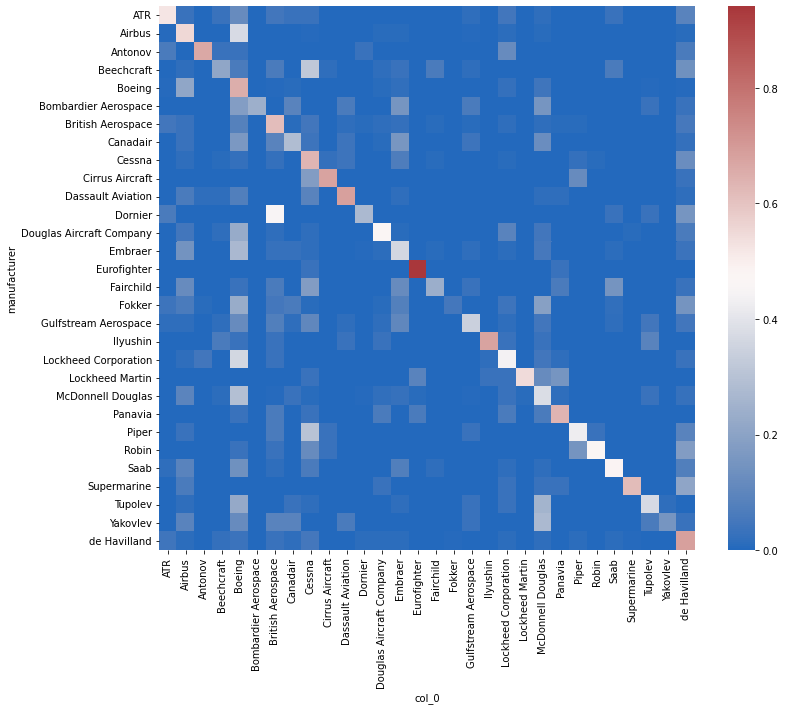

In [ ]:
# Confusion matrix in the test set with names

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME2],
                        classify_images(X_test_scaled, model_tl, test_df[TARGET_NAME2].astype('category').cat.categories),
                        normalize='index'),
            cmap='vlag',
            ax=ax);

Save the model

In [ ]:
# function save_model
import datetime
def save_model(model, basename):
  """Save tf/Keras model

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}.h5'.format(basename))
  return

In [ ]:
#file_dir = '/content/drive/MyDrive/image_classifier/base_dir.h5'
#base_model.save(file_dir)

In [ ]:
# apply the function save_model()
save_model(model_tl, TARGET_NAME2)

In [ ]:
# Ajoute accuracy.

# CONCLUSION :

the accuracy here is 64,13 % on the train. It's quite similar to the one of the Neural Network model. Transfer learning improves the ranking of the planes compared to SVM and neural networks there is much more red color in the prediction than other cases. The transfer learning process was more fast than the two others models. 